In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from scipy.stats import randint

from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score, precision_score, f1_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from scipy.stats import uniform, loguniform

import pickle


In [ ]:
## The following run in Terminal to facilitate BayesSearchCV
# pip install --force-reinstall "scikit-learn==0.23.2"

In [162]:
data_raw = pd.read_csv('./data/allposts_struc.csv')
data_vecd = pd.read_csv('./data/merged_with_bigrams.csv')

In [163]:
#remove extra index column that made it into data_vecd
data_vecd.drop(columns='index', inplace=True)
data_raw.drop(columns='index', inplace=True)

In [41]:
data_raw.isnull().sum().sort_values(ascending=False).head()

lem_selftext    0
mod_selftext    0
selftext        0
subreddit       0
created_utc     0
dtype: int64

In [42]:
#baseline accuracy
data_vecd.subreddit.value_counts(normalize=True)

relationship_advice    0.50775
pettyrevenge           0.49225
Name: subreddit, dtype: float64

In [164]:
#forgot to numify before fitting model 1, so run this cell here for model 1
# assign initial train_test_split based on str X
# change to numified X in subsequent models
X=data_raw['lem_selftext']
y=data_raw['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

In [170]:
data_vecd['subreddit'] = data_vecd['subreddit'].apply(lambda x: 0 if x=='pettyrevenge' else 1)
data_raw['subreddit'] = data_raw['subreddit'].apply(lambda x: 0 if x=='pettyrevenge' else 1)

In [171]:
data_raw.subreddit.value_counts(normalize=True)

1    0.50775
0    0.49225
Name: subreddit, dtype: float64

# Modeling

In [76]:
#custom stopwords: 'english', + unique lems + 'im' just because
my_words = ['wa', 'ha', 'doe', 'a', 'im']
custom_stop = text.ENGLISH_STOP_WORDS.union(my_words)

# Model 1: cvec -> MultinomialBayes
This scored very well (mid-90s) in all metrics.  Suspiciously high.  See Model2 explanation. 

---
# Model 2: DecisionTree with 0 hyperparams
This was just to get a picture of how the tree was making decisions, then I'd use that to guide BayesSearchCV params.  It also scored suspiciously high. Printing the tree text revealed that the source of success in Models 1 and 2 is likely due to key words _relationship_ and _revenge_.  As such, I will include the title words of both subreddits in the stopwords for all subsequent models.

In [7]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=custom_stop) ),
    ('mnb', MultinomialNB() ),
])

pipe_params = {
    'cvec__max_features': randint(500,8000),
    'cvec__min_df': uniform(.01, .05),
    'cvec__max_df': [.90, .98], #change to randint or uniform(.90,.98)?
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'mnb__alpha': uniform(.01,10)                    
}

In [9]:
vec_mnb_rs = RandomizedSearchCV(estimator = pipe, 
                                param_distributions=pipe_params, 
                                scoring = 'f1_weighted',
                                random_state=42,
                                n_iter=1000,
                                cv=5,
                                n_jobs=-1, verbose=1)

In [10]:
# vec_mnb_rs.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/helenmeigs/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 51.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 75.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 92.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 116.5min
[Parallel(n_jobs=-1)]: Done 5

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec',
                                              CountVectorizer(stop_words=frozenset({'a',
                                                                                    'about',
                                                                                    'above',
                                                                                    'across',
                                                                                    'after',
                                                                                    'afterwards',
                                                                                    'again',
                                                                                    'against',
                                                                                    'all',
                                                                                  

In [18]:
pkl_cvec_mnb_rs = './models/vec_mnb1.pkl'
with open (pkl_cvec_mnb_rs, 'wb') as file:
    pickle.dump(vec_mnb_rs, file)

In [153]:
with open(pkl_cvec_mnb_rs, 'rb') as file:
    mnb1_pickle = pickle.load(file)

In [161]:
Xa.value_counts()

relationship_advice    12000
Name: lem_selftext, dtype: int64

In [165]:
mnb1_pickle.score(X_train, y_train), mnb1_pickle.score(X_test, y_test)

(0.9616885248965604, 0.9593432710073183)

In [166]:
mnb1_pickle.best_params_

{'cvec__max_df': 0.98,
 'cvec__max_features': 6088,
 'cvec__min_df': 0.010093994176245532,
 'cvec__ngram_range': (1, 3),
 'mnb__alpha': 0.04218263604278682}

In [167]:
mnb1_pickle.best_estimator_['cvec']

CountVectorizer(max_df=0.98, max_features=6088, min_df=0.010093994176245532,
                ngram_range=(1, 3),
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

In [168]:
mnb1_pickle.best_estimator_['mnb']

MultinomialNB(alpha=0.04218263604278682)

In [118]:
#hand to calc scores manually because forgot to numify target before fitting first model...
def see_scores(model, X_test, y_test):
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(confusion_matrix(y_test, preds))
    
    print(f'\nAccuracy: {accuracy_score(y_test, preds).round(6)}')
    print(f'\nSensitivity: {(tp/(tp+fn)).round(6)}')
    print(f'\nPrecision: {tp/(tp+fp).round(6)}')
    print(f'\nSpecificity: {(tn/(tn+fp)).round(6)}')
    print(f'\nF1: {tp/(tp + 0.5*(fp + fn)).round(6)}')
    
    plot_confusion_matrix(model, X_test, y_test)
    

[[1896   85]
 [  76 1903]]

Accuracy: 0.959343

Sensitivity: 0.961597

Precision: 0.9572434607645876

Specificity: 0.957092

F1: 0.9594151751953617


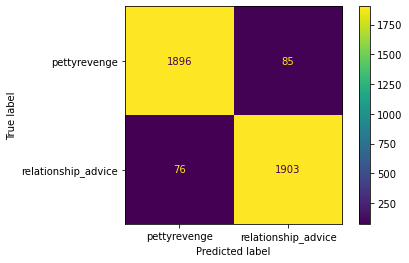

In [169]:
see_scores(mnb1_pickle, X_test, y_test)

## Model 2: Decision Tree base
First fit already vectorized data (concatenated 1-gram and bigrams) with no params - will be overfit, but use to guide ranges in BayesSearchCV.  Takeaways:
* add title words to stopwords ('relationship', 'advice', 'petty', 'revenge')
* max branch depth was 71, then 48, 38, 25.  Lower branch depth to reduce overfitting.
    * to achieve purity (leaf=1)

In [90]:
X0=data_vecd.drop(columns=['author','num_comments','timestamp','num_sentences','avg_words_per_sent', 'wordcount','comma_count','qmark_count', 'exclamatios','is_mobile','subreddit'])
y0=data_vecd['subreddit']
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, random_state=42, test_size=.33)

In [91]:
dt0 = DecisionTreeClassifier(random_state=42)
dt0.fit(X0_train, y0_train)

DecisionTreeClassifier(random_state=42)

In [92]:
dt0.score(X0_train, y0_train), dt0.score(X0_test, y0_test)

(1.0, 0.8772727272727273)

In [102]:
## 'Relationship' (#1), 'advice', 'petty', and 'revenge' all in top 10 nodes.  
## Should've seen that coming.
## adjust stopwords
#print(export_text(dt0, list(X0_train.columns)))

## Model 1a: same param as Model 1 but with updated stopwords
And a couple other tweaks to hone in on the ideal values from in first pipeline best_params.

In [110]:
#update
my_words = ['wa', 'ha', 'doe', 'a', 'im', 'relationship', 'advice','petty','revenge']
new_stop = text.ENGLISH_STOP_WORDS.union(my_words)

In [111]:
X = X=data_raw['lem_selftext']
y=data_raw['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

In [112]:
pipe_b = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stop) ),
    ('mnb', MultinomialNB() ),
])

pipe_b_params = {
    'cvec__max_features': randint(6000,10000), #updated and expanded since more limiting stopwords
    'cvec__min_df': uniform(.001, .05),
    'cvec__max_df': uniform(.95, 1.), #updated to range, not discrete
    'cvec__ngram_range': [(1,3), (2,4)], #updated
    'mnb__alpha': uniform(.001,1)   # updated                   
}

In [113]:
b_vec_mnb = RandomizedSearchCV(estimator = pipe_b, 
                                param_distributions=pipe_b_params, 
                                scoring = 'f1_weighted',
                                random_state=42,
                                n_iter=1000,
                                cv=5,
                                n_jobs=-1, verbose=1)

In [114]:
# %%time
# b_vec_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/helenmeigs/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 47.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 70.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 96.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 124.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 155.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 190.3min
[Parallel(n_jobs=-1)]: Done

CPU times: user 1min 31s, sys: 3min 17s, total: 4min 49s
Wall time: 3h 10min 53s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec',
                                              CountVectorizer(stop_words=frozenset({'a',
                                                                                    'about',
                                                                                    'above',
                                                                                    'across',
                                                                                    'advice',
                                                                                    'after',
                                                                                    'afterwards',
                                                                                    'again',
                                                                                    'against',
                                                                               

In [122]:
pkl_b_vec_mnb = './models/vec_mnb2.pkl'
with open (pkl_b_vec_mnb, 'wb') as file:
    pickle.dump(b_vec_mnb, file)

In [152]:
with open(pkl_b_vec_mnb, 'rb') as file:
    mnb2_pickle = pickle.load(file)

In [145]:
mnb2_pickle.best_params_

{'cvec__max_df': 1.0018357991197289,
 'cvec__max_features': 6112,
 'cvec__min_df': 0.0019897829173627195,
 'cvec__ngram_range': (1, 3),
 'mnb__alpha': 0.3077765995221412}

In [146]:
mnb2_pickle.score(X_train, y_train), mnb2_pickle.score(X_test, y_test)

(0.963179184532175, 0.9575753030725069)

In [147]:
mnb2_pickle.best_params_

{'cvec__max_df': 1.0018357991197289,
 'cvec__max_features': 6112,
 'cvec__min_df': 0.0019897829173627195,
 'cvec__ngram_range': (1, 3),
 'mnb__alpha': 0.3077765995221412}

[[1890   91]
 [  77 1902]]

Accuracy: 0.957576

Sensitivity: 0.961091

Precision: 0.9543401906673357

Specificity: 0.954064

F1: 0.9577039274924471


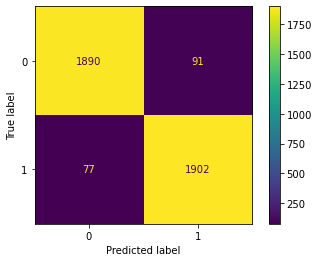

In [149]:
#see_scores(b_vec_mnb, X_test, y_test)
see_scores(mnb2_pickle, X_test, y_test)

## Model 2a: Decision Tree with BayesSearch
Cvec parameters are guided by results from model 1, even though that was using different estimator. Decision Tree parameters are more of a shot in the dark, but are selected in theory to reduce overfitting.

In [172]:
tree_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stop, max_df=.98, ngram_range=(1,3)) ),
    #cvec params based on best_params_ from vec_mnb2
    ('tree', DecisionTreeClassifier(random_state=42, splitter='random')) 
    # random splitter to reduce overfitting
])

tree_pipe_params = {
    'cvec__max_features': Integer(5500,8000),   
    'cvec__min_df': Real(.001, .03),
    
    'tree__max_depth': Integer(20,60),  #max at dtree base params was ~70
    'tree__min_samples_leaf': Integer(5,100),
    'tree__ccp_alpha': uniform(.0,10),
}   

In [173]:
dtree_bs = BayesSearchCV(estimator = tree_pipe,
                         search_spaces= tree_pipe_params,
                         scoring = 'f1_weighted',
                         n_iter = 50,
                         cv = 5,
                         optimizer_kwargs = {'base_estimator': 'RF'},
                         random_state=42, verbose = 1)

ValueError: Dimension has to be a list or tuple.

## Model 3: Random Forest with BayesSearch

In [136]:
forest_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stop, max_df=.95) ),
    ('rf', RandomForestClassifier(bootstrap=True) )
])

forest_params = {'rf__n_estimators': Integer(500,1000),
                 'rf__max_depth': Integer(20,70),
                 'rf__min_samples_split': Integer(2,10),
                 'rf__min_samples_leaf': Integer(2,10),
                 'rf__ccp_alpha': Real(.01, 1.0)  #from best_params_ model 2a
                }

TypeError: __init__() missing 2 required positional arguments: 'low' and 'high'

In [ ]:
forest_bs = BayesSearchCV(estimator = forest_pipe,
                         search_spaces = forest_params,
                         scoring='f1_weighted',
                         n_iter=100,
                         cv=5,
                         random_state=42, verbose=1)

In [ ]:
h = {'Column Name': df_X_train.columns, 'Feature Importance': forest_bs.best_estimator_.feature_importances}
feat_imp = pd.Dataframe(h)

In [ ]:
feat_imp.sort_values(by=['Feature Importance'], ascending=False).head(20)